# Case Study on Loss Given Default

# Context: 
    
CNB Bank deals in all kinds of car loans. Customer first apply for loan after that company validates the customer 
eligibility for loan. In case the borrower doesn’t pay back the loan, the losses are to be incurred by the bank.
LGD stands for Loss given default so it means when a customer at a bank defaults on his loan how much money does the bank lose. 
The customer might have paid some amount back or no amount at all.The bank wants to know if the amount the bank loses can be 
predicted for new customers who apply for a loan from the past data of all defaulters and their pending amounts

# Problem:

The bank wants to automate the loss estimation based on customer detail provided while applying for loan. These details are Age, 
Years of Experience, Number of cars, Gender, Marital Status. To automate this process, they have given a problem to identify the 
loss estimation given that the customers is a defaulter, those are eligible for loan amount so that they get to know what 
features are leading to defaults up to which amount. Here are the details about the data set.

Data:

Variable - Description <br>
Ac_No - The account of customer used as identifier <br>
Age - Age of borrower (16-70) <br>
Years of Experience -  Working experience (0-53) <br>
Number of Cars - Possessed cars (1, 2, 3, 4) <br>
Gender - Male/Female <br>
Married - Married/Single <br>
Loss in Thousands - Target variable <br>


In [1]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # this is for visualization
import seaborn as sns # for visualization
%matplotlib inline
import statsmodels.formula.api as sm
import scipy, scipy.stats
import math # log function is inside this library
# this is used to get the plots inline i.e. in the same page
from collections import Counter

In [2]:
# read the csv file into a dataframe
df=pd.read_csv("../data/LGD.csv")

In [3]:
df.head(4)

,Ac_No,Age,Years of Experience,Number of Vehicles,Gender,Married,Losses in Thousands
0,150024,24,5,1,M,Married,203.319595
1,144880,31,10,1,F,Single,402.197302
2,133742,56,37,1,M,Married,553.132096
3,151282,52,31,1,F,Married,292.430579


In [4]:
# lets do a basic EDA ( exploratory data analysis) on the file
df.info() # this tells us 15290 rows & 7 columns
#df.shape will also give the same info
#df.info also tells us there are no NULL values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15290 entries, 0 to 15289
Data columns (total 7 columns):
Ac_No                  15290 non-null int64
Age                    15290 non-null int64
Years of Experience    15290 non-null int64
Number of Vehicles     15290 non-null int64
Gender                 15290 non-null object
Married                15290 non-null object
Losses in Thousands    15290 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 836.3+ KB


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ac_No,15290.0,149961.789339,28947.841061,100002.000000,124900.500000,149897.500000,175019.500000,200454.0
Age,15290.0,42.328254,18.280511,16.000000,24.000000,42.000000,61.000000,70.0
Years of Experience,15290.0,23.732897,17.850707,0.000000,6.000000,23.000000,42.000000,53.0
Number of Vehicles,15290.0,2.495880,0.953776,1.000000,2.000000,2.000000,3.000000,4.0
Losses in Thousands,15290.0,389.859718,253.729433,12.534521,226.434217,354.937874,488.676927,3500.0


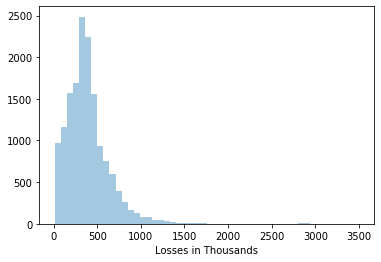

In [6]:
#to plot histograms
sns.distplot(df['Losses in Thousands'],kde=False,bins=50)

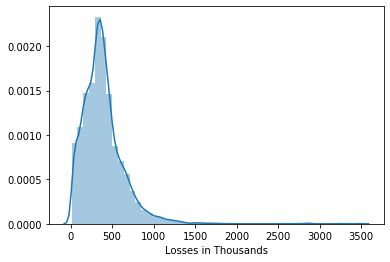

In [7]:
# this probably means we shud take the log to normalize the data
sns.distplot((df['Losses in Thousands']),kde=True,bins=50)
# map function is used to apply any function on each element of a series/list
# now the distribution looks normal

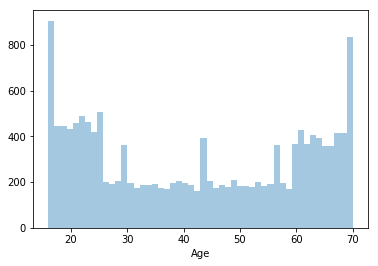

In [8]:
sns.distplot(df['Age'],kde=False,bins=50)

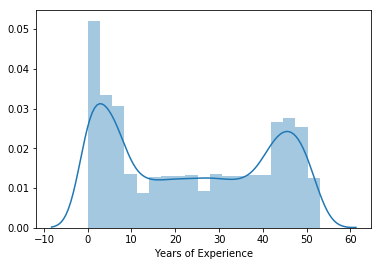

In [9]:
sns.distplot(df['Years of Experience'])

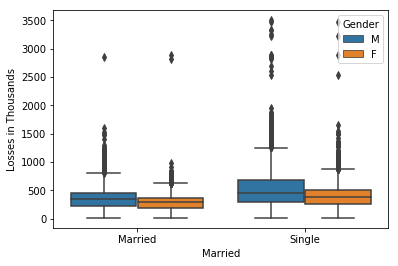

In [10]:
sns.boxplot(x="Married",y="Losses in Thousands",data=df,hue="Gender")
#this shows that sinle ppl & Male are the worst

In [11]:
df.corr()
# we see a high co-relation between Age and Years of Experience 
# which is obvious as with Age your Experience increases

,Ac_No,Age,Years of Experience,Number of Vehicles,Losses in Thousands
Ac_No,1.000000,0.008291,0.008437,-0.003056,-0.000794
Age,0.008291,1.000000,0.997161,0.008366,-0.442962
Years of Experience,0.008437,0.997161,1.000000,0.008545,-0.442115
Number of Vehicles,-0.003056,0.008366,0.008545,1.000000,-0.011553
Losses in Thousands,-0.000794,-0.442962,-0.442115,-0.011553,1.000000


In [12]:
pd.get_dummies(df['Gender'],drop_first=True)

,M
0,1
1,0
2,1
3,0
4,1
5,1
6,0
7,0
8,1
9,0


In [13]:
# first lets build a simple model with all variables and as is
# we will have to convert the string variables to dummy variables 
#dummy_var1=pd.get_dummies(df['Gender'],drop_first=True)
dummy_var1=pd.get_dummies(df['Gender'])
#simillarly for married
dummy_var2=pd.get_dummies(df['Married'])
#dummy_var2=pd.get_dummies(df['Married'],drop_first=True)
dummy_var2.head()
# merge the above 2 dataframe with the original dataframe df
df_new=pd.concat([df,dummy_var1,dummy_var2],axis=1)
df_new.head()

,Ac_No,Age,Years of Experience,Number of Vehicles,Gender,Married,Losses in Thousands,F,M,Married,Single
0,150024,24,5,1,M,Married,203.319595,0,1,1,0
1,144880,31,10,1,F,Single,402.197302,1,0,0,1
2,133742,56,37,1,M,Married,553.132096,0,1,1,0
3,151282,52,31,1,F,Married,292.430579,1,0,1,0
4,174407,20,3,1,M,Single,246.540576,0,1,0,1


In [14]:
df_new.head()

,Ac_No,Age,Years of Experience,Number of Vehicles,Gender,Married,Losses in Thousands,F,M,Married,Single
0,150024,24,5,1,M,Married,203.319595,0,1,1,0
1,144880,31,10,1,F,Single,402.197302,1,0,0,1
2,133742,56,37,1,M,Married,553.132096,0,1,1,0
3,151282,52,31,1,F,Married,292.430579,1,0,1,0
4,174407,20,3,1,M,Single,246.540576,0,1,0,1


In [15]:
#now we no longer need Married and gender Columns. We will use their
#dummies instead
df_new2=df_new.drop(['Gender','Married'],axis=1)
df_new2.head()

,Ac_No,Age,Years of Experience,Number of Vehicles,Losses in Thousands,F,M,Single
0,150024,24,5,1,203.319595,0,1,0
1,144880,31,10,1,402.197302,1,0,1
2,133742,56,37,1,553.132096,0,1,0
3,151282,52,31,1,292.430579,1,0,0
4,174407,20,3,1,246.540576,0,1,1


In [16]:
#decide your regressor and predictor variables
x=df_new2[["Age","Number of Vehicles","M","Single"]]
y=df_new2["Losses in Thousands"]

In [17]:
#split the data into train and test
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

In [18]:
print(x_train.count())
print(y_test.count())

Age                   10703
Number of Vehicles    10703
M                     10703
Single                10703
dtype: int64
4587


In [19]:
from sklearn.linear_model import LinearRegression # import the functions

lm = LinearRegression() #call the function

lm.fit(x_train,y_train)# fit the model

print(lm.intercept_) # see the intercept
print(lm.coef_)# see the betas
"""
#see the error parameters
from sklearn import metrics

#make prediction
pred=lm.predict(x_test)
print(metrics.mean_absolute_error(y_test,pred))
from sklearn.metrics import r2_score
r2_score(y_test, pred)
"""

536.3918314311627
[ -6.1215775    0.20975509  91.17454455 133.06754296]


'\n#see the error parameters\nfrom sklearn import metrics\n\n#make prediction\npred=lm.predict(x_test)\nprint(metrics.mean_absolute_error(y_test,pred))\nfrom sklearn.metrics import r2_score\nr2_score(y_test, pred)\n'

In [20]:
#see the error parameters
from sklearn import metrics

#make prediction
pred=lm.predict(x_test)
print(metrics.mean_absolute_error(y_test,pred))
from sklearn.metrics import r2_score
r2_score(y_test, pred)

148.4575698584855


0.2961799279909947

In [21]:
#so the linear regression equation we get is
#----loss in thousands=539.65-6.14*Age-1.79*Number of Vehicles+97*M+136*Single
#so according to above--
#Young people (- coeff)and Male(+ coeff) & Unmarried person(+coeff)
#dont pay their loans back
#lets get the P values of each predictors 
from statsmodels.api import add_constant
X2 = add_constant(x_train)

lm= sm.OLS(y_train,X2)

lm2=lm.fit()

lm2.pvalues
# sm.OLS by default does not add an intercept in the model.
#so we manually added it by the first line


const                  0.000000e+00
Age                    0.000000e+00
Number of Vehicles     9.208499e-01
M                     1.596166e-110
Single                2.583042e-227
dtype: float64

In [22]:
#to see the summary
print(lm2.summary())

                             OLS Regression Results                            
Dep. Variable:     Losses in Thousands   R-squared:                       0.304
Model:                             OLS   Adj. R-squared:                  0.304
Method:                  Least Squares   F-statistic:                     1168.
Date:                 Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                         08:40:26   Log-Likelihood:                -72344.
No. Observations:                10703   AIC:                         1.447e+05
Df Residuals:                    10698   BIC:                         1.447e+05
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                536.3

In [23]:
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [24]:
regression_model.score(x_train, y_train)

0.3039979036075725